<a href="https://colab.research.google.com/github/ConorD28/Reds/blob/main/Reds_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
df = pd.read_csv('data (1).csv')

In [ ]:
df.head()

In [6]:
df.isnull().sum()

PID                             0
INNING_KEY                      0
BATTER_IN_INNING_KEY            0
PITCH_NUMBER                    0
OUT_KEY                         0
BALLS                           0
STRIKES                         0
IS_RUNNER_ON_1B                 0
IS_RUNNER_ON_2B                 0
IS_RUNNER_ON_3B                 0
PITCHER_KEY                     0
THROW_SIDE_KEY                  0
PITCH_TYPE_TRACKED_KEY          0
EVENT_RESULT_KEY             7258
PITCH_RESULT_KEY                0
INDUCED_VERTICAL_BREAK          0
HORIZONTAL_BREAK                0
SPIN_RATE_ABSOLUTE              0
RELEASE_SPEED                   0
RELEASE_SIDE                    0
RELEASE_HEIGHT                  0
RELEASE_EXTENSION               0
HORIZONTAL_APPROACH_ANGLE       0
VERTICAL_APPROACH_ANGLE         0
PLATE_X                         0
PLATE_Z                         0
dtype: int64

In [7]:
df_pitchers_grouped = df.groupby(by = "PITCHER_KEY")
df_pitchers_means = df_pitchers_grouped.aggregate(np.mean) #get mean for each stat by pitcher

<ipython-input-7-a11693672652>:2: FutureWarning: The operation <function mean at 0x7aaa80124550> failed on a column. If any error is raised, this will raise an exception in a future version of pandas. Drop these columns to avoid this warning.
  df_pitchers_means = df_pitchers_grouped.aggregate(np.mean) #get mean for each stat by pitcher


In [ ]:
df_pitchers_grouped.head()

In [8]:
df_pitchers_means2 = df_pitchers_means.iloc[:, [10,11,12,13,14,15,16,17,18]] #get stats that dewpoint will affect

In [9]:
df_sorted = df.sort_values('PITCHER_KEY')

In [10]:
df_sorted2 = df_sorted.iloc[:, [10,15,16,17,18,19,20,21,22,23]]

In [ ]:
df_sorted2.columns

Index(['PITCHER_KEY', 'INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK',
       'SPIN_RATE_ABSOLUTE', 'RELEASE_SPEED', 'RELEASE_SIDE', 'RELEASE_HEIGHT',
       'RELEASE_EXTENSION', 'HORIZONTAL_APPROACH_ANGLE',
       'VERTICAL_APPROACH_ANGLE'],
      dtype='object')

In [ ]:
df_pitchers_means2.columns

Index(['INDUCED_VERTICAL_BREAK', 'HORIZONTAL_BREAK', 'SPIN_RATE_ABSOLUTE',
       'RELEASE_SPEED', 'RELEASE_SIDE', 'RELEASE_HEIGHT', 'RELEASE_EXTENSION',
       'HORIZONTAL_APPROACH_ANGLE', 'VERTICAL_APPROACH_ANGLE'],
      dtype='object')

In [11]:
#Get DEWPOINT_AFFECTED:
j = 0
prev = df_sorted2.iloc[0][0]
df_sorted3 = df_sorted2.iloc[:, [1,2,3,4,5,6,7,8,9]] #removes Pitcher Key
for i in range(9889):
  if df_sorted2.iloc[i][0] != prev: #once pitcher changes increase j
    j = j + 1
  pitch_values = df_sorted3.iloc[i] - df_pitchers_means2.iloc[j] #gets how far off stats are from pitcher's mean for those stats for each pitch
  pitch_values2 = abs(pitch_values)
  dp_probability = pitch_values2.sum()/1312 #get dewpoit probability by summing how far off stats are from pitcher's mean then dividing by 1350
  df_sorted.at[i, 'DEWPOINT_AFFECTED'] = dp_probability
  prev = df_sorted2.iloc[i][0]

In [ ]:
df_sorted['DEWPOINT_AFFECTED'].min()

0.006229236789951102

In [ ]:
df_sorted['DEWPOINT_AFFECTED'].max()

0.9996575927482338

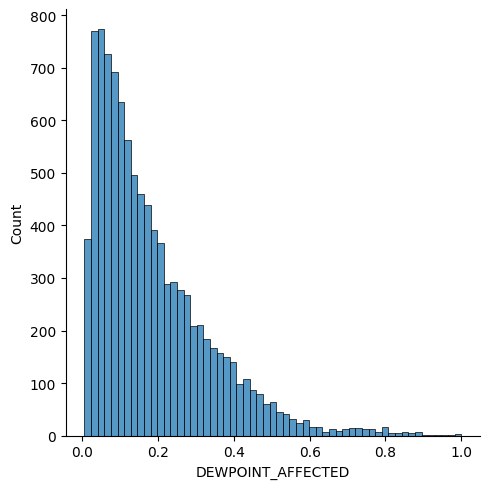

In [ ]:
sns.displot(data = df_sorted, x = 'DEWPOINT_AFFECTED')

Text(0.5, 1.0, 'Pitcher Key vs Dewpoint Affected')

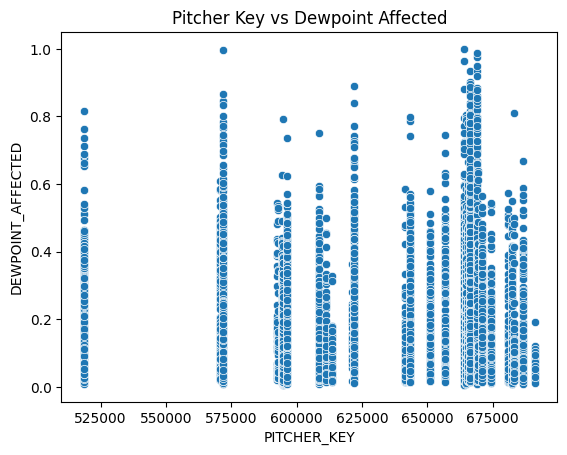

In [ ]:
sns.scatterplot(data = df_sorted, x = 'PITCHER_KEY', y = 'DEWPOINT_AFFECTED').set_title("Pitcher Key vs Dewpoint Affected")

In [ ]:
df_submit = df_sorted[['PID', 'DEWPOINT_AFFECTED']]
df_submit.to_csv('submission.csv') #write csv

In [12]:
from sklearn.model_selection import train_test_split
from numpy.random.mtrand import random_sample
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [13]:
def Scores(y, y_pred, y_full):
  MSE = mean_squared_error(y, y_pred)
  MAE = mean_absolute_error(y, y_pred)
  Normalized_RMSE = (np.sqrt(MSE)/np.mean(y_full))*100
  Normalized_MAE = (MAE/np.mean(y_full))*100
  Avg_Normalized_Score = (Normalized_RMSE + Normalized_MAE)/2
  print(f'Avg. Normalized Score:{ Avg_Normalized_Score:.1f}%')
  print(f'Normalized RMSE:{ Normalized_RMSE:.1f}%')
  print(f'Normalized MAE:{ Normalized_MAE:.2f}%')
  print(f'MAE:{ MAE:.3f}')
  print(f'RMSE:{ np.sqrt(MSE):.3f}')
  return Avg_Normalized_Score

In [14]:
def RLE_Model(X, y, choice): #Function to run Ridge, Lasso, or ElasticNet model
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0) #Train/Test

  if(choice=="Ridge"):
    alphas = np.geomspace(1e-10, 1e10, num=100)
    pipeline = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))
    pipeline.fit(X_train, y_train)

  if(choice=="Lasso"):
    alphas = np.geomspace(1e-10, 1e10, num=21)
    pipeline = make_pipeline(StandardScaler(), LassoCV(alphas=alphas))
    pipeline.fit(X_train, y_train)

  if(choice=="Elastic"):
    l1_ratio = [0, 0.3, 0.5, 0.7,  0.9, 1]
    alphas = np.geomspace(1e-10, 1e10, num=100)
    pipeline = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas, l1_ratio=l1_ratio, max_iter=100000))
    pipeline.fit(X_train, y_train)

  print(f'Chosen alpha  {pipeline.steps[1][1].alpha_:.6f}')
  print(f'Intercept (b) {pipeline.steps[1][1].intercept_:.6f}')
  print(pd.Series(pipeline.steps[1][1].coef_, index=X.columns),'\n')

  #Predicted training values:
  y_train_pred = pipeline.predict(X_train)
  print(y_train_pred)
  print()

  #Training Scores:
  Avg_N_Score_train = Scores(y_train, y_train_pred, y)
  print()

  #Predicted test set values:
  y_test_pred = pipeline.predict(X_test)
  print(y_test_pred)
  print()

  #Test Set Scores:
  Avg_N_Score_test = Scores(y_test, y_test_pred, y)
  print(f'Difference of avg normalized scores:{ Avg_N_Score_test - Avg_N_Score_train:.3f}%') #Difference between testing and traing scores to check if my bias-variance tradeoff is good
  print()

In [15]:
from sklearn.svm import LinearSVR

def SVM_model(X, y):
  svm_reg = make_pipeline(StandardScaler(), LinearSVR(epsilon=0.1))
  svm_reg.fit(X, y)

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
  y_train_pred = svm_reg.predict(X_train)
  print(y_train_pred)

  Avg_N_Score_train = Scores(y_train, y_train_pred, y)
  print()

  y_test_pred = svm_reg.predict(X_test)
  print(y_test_pred)
  print()

  Avg_N_Score_test = Scores(y_test, y_test_pred, y)
  print(f'Difference of avg scores:{ Avg_N_Score_test - Avg_N_Score_train:.3f}%') #Difference between testing and traing scores to check if my bias-variance tradeoff is good
  print()

In [24]:
X = df_sorted.loc[:,'INDUCED_VERTICAL_BREAK':'VERTICAL_APPROACH_ANGLE']
y = df_sorted['DEWPOINT_AFFECTED']

In [ ]:
RLE_Model(X, y, 'Lasso') #really bad for all 3 options
SVM_Model(X, y)

In [ ]:
#Do the following to get autosklearn to work in Google Colab:
!pip install Cython==0.29.36
!pip uninstall scipy -y
!pip install scipy==1.9
!pip uninstall pyparsing -y
!pip install pyparsing==2.4
!pip uninstall scikit_learn -y
!pip uninstall imbalanced-learn -y
!pip uninstall mlxtend -y
!pip uninstall yellowbrick -y
!pip install scikit-learn==0.24.2 --no-build-isolation
!pip install auto-sklearn

In [ ]:
#Do the following to get autosklearn to work in Google Colab:
import os
os._exit(00)

In [1]:
import autosklearn

In [19]:
from pprint import pprint
import sklearn.datasets
import sklearn.metrics
import autosklearn.regression
import matplotlib.pyplot as plt

def Auto_Model(X, y): #Uses AutoML to make a model
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0) #Train/Test

  automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=1800,
    per_run_time_limit=450,
    tmp_folder="/tmp/autosklearn_regression_example_tmp",
  )
  automl.fit(X_train, y_train, dataset_name="Pitches")

  #Print models used:
  print(automl.leaderboard())
  print()

  #Predicted training values:
  y_train_pred = automl.predict(X_train)
  print(y_train_pred)
  print()

  #Training Scores:
  Avg_N_Score_train = Scores(y_train, y_train_pred, y)
  print()

  #Predicted testing values:
  test_predictions = automl.predict(X_test)
  print(test_predictions)
  print()

  #Testing Scores:
  Avg_N_Score_test = Scores(y_test, test_predictions, y)
  print(f'Difference of avg normalized scores:{ Avg_N_Score_test - Avg_N_Score_train:.3f}%') #Difference between testing and traing scores to check if my bias-variance tradeoff is good
  print()

In [ ]:
Auto_Model(X,y) #performed really bad

In [22]:
#These variables have text data so I drop these
df_sorted.drop('THROW_SIDE_KEY', axis=1, inplace=True)
df_sorted.drop('PITCH_TYPE_TRACKED_KEY', axis=1, inplace=True)
df_sorted.drop('EVENT_RESULT_KEY', axis=1, inplace=True)
df_sorted.drop('PITCH_RESULT_KEY', axis=1, inplace=True)

In [ ]:
X = df_sorted.loc[:, 'PID':'PLATE_Z']
y = df_sorted['DEWPOINT_AFFECTED']
RLE_Model(X, y, 'Lasso') #really bad for all 3 options
SVM_Model(X, y)

In [27]:
Auto_Model(X, y)

          rank  ensemble_weight                 type      cost    duration
model_id                                                                  
8            1             0.22          extra_trees  0.825071  124.090265
15           2             0.32  k_nearest_neighbors  0.826249    2.310741
11           3             0.12        random_forest  0.844509   60.181752
22           4             0.02    gradient_boosting  0.850942    2.398202
18           5             0.02    gradient_boosting  0.861276   24.125505
4            6             0.18    gradient_boosting  0.872370    3.908713
29           7             0.08        random_forest  0.985392  109.490915
3            8             0.04           libsvm_svr  0.986604  139.091677

[0.09412284 0.75179282 0.08432555 ... 0.08221722 0.23117113 0.06251022]

Avg. Normalized Score:34.4%
Normalized RMSE:43.3%
Normalized MAE:25.49%
MAE:0.047
RMSE:0.080

[0.12285225 0.17486982 0.15634545 ... 0.16869962 0.1800665  0.21227675]

Avg. Norm